In [1]:
import datetime
import pandas as pd
import numpy as np
import re
import os
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *

print(os.getpid())

def init_spark(app_name, master):
    """
    :params app_name: Name of the app
    :params master_config: eg. local[4]
    :returns SparkContext
    """
    spark = SparkSession.builder.appName(app_name)\
                        .master(master)\
                        .getOrCreate() # Avoid duplicately create SparkSession
    
    return spark

spark = init_spark("Term Project", "local[*]")

# Adjust the date below, and you can get the date format from start to end
date_start = datetime.datetime(2020, 11, 1,hour=0)
date_end = datetime.datetime(2020, 11, 13,hour=0)
date_delta = datetime.timedelta(hours=1)

df = []

sta_1 = '05F0287N' # 南端
sta_2 = '05F0055N' # 北端
dist = 28.7-5.5 # 

3994


In [2]:
# For differnet M0X file, you may need to change the schema of 'head'.
def load_csv_file(df, date_start, date_end, date_delta):
    date = date_start
    init = 0
    head = StructType([\
        StructField("VehicleType", IntegerType(), True),\
        StructField("DetectionTime_O", StringType(), True),\
        StructField("GantryID_O", StringType(), True),\
        StructField("DetectionTime_D", StringType(), True),\
        StructField("GantryID_D", StringType(), True),\
        StructField("TripLength", DoubleType(), True),\
        StructField("TripEnd", StringType(), True),\
        StructField("TripInformation", StringType(), True)])

    ## Load data to df
    while date_start < date_end:
        # convert date to string by a assigned format
        dir_path = date.strftime("M06A/%Y%m%d/%H/") 
        filename = date.strftime("TDCS_M06A_%Y%m%d_%H0000.csv")
        path = dir_path + filename
        # read csv by spark
        print('load file:',path)
        if init == 0:
            df = spark.read.csv(path,header=False,schema=head)
            init = 1
        else:
            tmp = spark.read.csv(path,header=False,schema=head)
            df = df.union(tmp)
        # increment the date iterator
        date = date_start + date_delta
        date_start = date
    print("done")
    return df

def compute_avg_speed(df, sta_1, sta_2, dist):
    # select the data which goes through sta_1 and sta_2, drop the data which DetectionTime_O == DetectionTime_D
    df = df.filter((df.DetectionTime_O != df.DetectionTime_D) & df.TripInformation.contains(sta_1) & df.TripInformation.contains(sta_2))

    # compute average for every trip
    df = df.withColumn('pos1',F.instr(df.TripInformation, sta_1))
    df = df.withColumn('pos2',F.instr(df.TripInformation, sta_2))
    df = df.withColumn('sta_1_time', F.to_timestamp(df.TripInformation.substr(df.pos1 - 20, F.lit(19))).cast(LongType()))
    df = df.withColumn('sta_2_time', F.to_timestamp(df.TripInformation.substr(df.pos2 - 20, F.lit(19))).cast(LongType()))
    df = df.withColumn('diff', F.abs(df.sta_1_time - df.sta_2_time))
    df = df.withColumn('avg_speed', F.round(F.lit(dist) / df.diff * F.lit(3600), 1))
    
    return df

In [3]:
df = load_csv_file(df, date_start, date_end, date_delta)
df = compute_avg_speed(df, sta_1, sta_2,dist)

load file: M06A/20201101/00/TDCS_M06A_20201101_000000.csv
load file: M06A/20201101/01/TDCS_M06A_20201101_010000.csv
load file: M06A/20201101/02/TDCS_M06A_20201101_020000.csv
load file: M06A/20201101/03/TDCS_M06A_20201101_030000.csv
load file: M06A/20201101/04/TDCS_M06A_20201101_040000.csv
load file: M06A/20201101/05/TDCS_M06A_20201101_050000.csv
load file: M06A/20201101/06/TDCS_M06A_20201101_060000.csv
load file: M06A/20201101/07/TDCS_M06A_20201101_070000.csv
load file: M06A/20201101/08/TDCS_M06A_20201101_080000.csv
load file: M06A/20201101/09/TDCS_M06A_20201101_090000.csv
load file: M06A/20201101/10/TDCS_M06A_20201101_100000.csv
load file: M06A/20201101/11/TDCS_M06A_20201101_110000.csv
load file: M06A/20201101/12/TDCS_M06A_20201101_120000.csv
load file: M06A/20201101/13/TDCS_M06A_20201101_130000.csv
load file: M06A/20201101/14/TDCS_M06A_20201101_140000.csv
load file: M06A/20201101/15/TDCS_M06A_20201101_150000.csv
load file: M06A/20201101/16/TDCS_M06A_20201101_160000.csv
load file: M06

load file: M06A/20201107/03/TDCS_M06A_20201107_030000.csv
load file: M06A/20201107/04/TDCS_M06A_20201107_040000.csv
load file: M06A/20201107/05/TDCS_M06A_20201107_050000.csv
load file: M06A/20201107/06/TDCS_M06A_20201107_060000.csv
load file: M06A/20201107/07/TDCS_M06A_20201107_070000.csv
load file: M06A/20201107/08/TDCS_M06A_20201107_080000.csv
load file: M06A/20201107/09/TDCS_M06A_20201107_090000.csv
load file: M06A/20201107/10/TDCS_M06A_20201107_100000.csv
load file: M06A/20201107/11/TDCS_M06A_20201107_110000.csv
load file: M06A/20201107/12/TDCS_M06A_20201107_120000.csv
load file: M06A/20201107/13/TDCS_M06A_20201107_130000.csv
load file: M06A/20201107/14/TDCS_M06A_20201107_140000.csv
load file: M06A/20201107/15/TDCS_M06A_20201107_150000.csv
load file: M06A/20201107/16/TDCS_M06A_20201107_160000.csv
load file: M06A/20201107/17/TDCS_M06A_20201107_170000.csv
load file: M06A/20201107/18/TDCS_M06A_20201107_180000.csv
load file: M06A/20201107/19/TDCS_M06A_20201107_190000.csv
load file: M06

In [4]:
df.show()

+-----------+-------------------+----------+-------------------+----------+----------+-------+--------------------+----+----+----------+----------+----+---------+
|VehicleType|    DetectionTime_O|GantryID_O|    DetectionTime_D|GantryID_D|TripLength|TripEnd|     TripInformation|pos1|pos2|sta_1_time|sta_2_time|diff|avg_speed|
+-----------+-------------------+----------+-------------------+----------+----------+-------+--------------------+----+----+----------+----------+----+---------+
|         31|2020-11-01 00:41:06|  05F0438N|2020-11-01 01:21:40|  03F0337S|      66.3|      Y|2020-11-01 00:41:...|  81| 111|1604191835|1604192747| 912|     91.6|
|         31|2020-11-01 00:05:10|  05F0309N|2020-11-01 00:36:51|  03F0337S|      58.2|      Y|2020-11-01 00:05:...|  51|  81|1604189201|1604190119| 918|     91.0|
|         31|2020-11-01 00:44:12|  05F0528N|2020-11-01 01:18:53|  03A0015N|      63.9|      Y|2020-11-01 00:44:...| 111| 141|1604192120|1604193014| 894|     93.4|
|         32|2020-11-0

In [5]:
speed = [row.avg_speed for row in df.select('avg_speed').collect()] # convert column to list
pd_df = spark.createDataFrame(speed,schema=FloatType()).toPandas() # convert list to pandas dataframe
ax = sns.kdeplot(pd_df['value'],shade=True,linewidth=3) # pandas dataframe plot

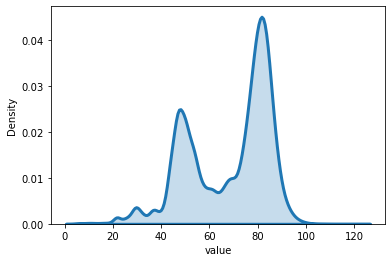

load file: M06A/20201101/00/TDCS_M06A_20201101_000000.csv
load file: M06A/20201101/01/TDCS_M06A_20201101_010000.csv
load file: M06A/20201101/02/TDCS_M06A_20201101_020000.csv
load file: M06A/20201101/03/TDCS_M06A_20201101_030000.csv
load file: M06A/20201101/04/TDCS_M06A_20201101_040000.csv
load file: M06A/20201101/05/TDCS_M06A_20201101_050000.csv
load file: M06A/20201101/06/TDCS_M06A_20201101_060000.csv
load file: M06A/20201101/07/TDCS_M06A_20201101_070000.csv
load file: M06A/20201101/08/TDCS_M06A_20201101_080000.csv
load file: M06A/20201101/09/TDCS_M06A_20201101_090000.csv
load file: M06A/20201101/10/TDCS_M06A_20201101_100000.csv
load file: M06A/20201101/11/TDCS_M06A_20201101_110000.csv
load file: M06A/20201101/12/TDCS_M06A_20201101_120000.csv
load file: M06A/20201101/13/TDCS_M06A_20201101_130000.csv
load file: M06A/20201101/14/TDCS_M06A_20201101_140000.csv
load file: M06A/20201101/15/TDCS_M06A_20201101_150000.csv
load file: M06A/20201101/16/TDCS_M06A_20201101_160000.csv
load file: M06

load file: M06A/20201107/08/TDCS_M06A_20201107_080000.csv
load file: M06A/20201107/09/TDCS_M06A_20201107_090000.csv
load file: M06A/20201107/10/TDCS_M06A_20201107_100000.csv
load file: M06A/20201107/11/TDCS_M06A_20201107_110000.csv
load file: M06A/20201107/12/TDCS_M06A_20201107_120000.csv
load file: M06A/20201107/13/TDCS_M06A_20201107_130000.csv
load file: M06A/20201107/14/TDCS_M06A_20201107_140000.csv
load file: M06A/20201107/15/TDCS_M06A_20201107_150000.csv
load file: M06A/20201107/16/TDCS_M06A_20201107_160000.csv
load file: M06A/20201107/17/TDCS_M06A_20201107_170000.csv
load file: M06A/20201107/18/TDCS_M06A_20201107_180000.csv
load file: M06A/20201107/19/TDCS_M06A_20201107_190000.csv
load file: M06A/20201107/20/TDCS_M06A_20201107_200000.csv
load file: M06A/20201107/21/TDCS_M06A_20201107_210000.csv
load file: M06A/20201107/22/TDCS_M06A_20201107_220000.csv
load file: M06A/20201107/23/TDCS_M06A_20201107_230000.csv
load file: M06A/20201108/00/TDCS_M06A_20201108_000000.csv
load file: M06

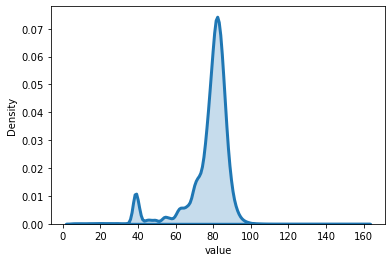

In [7]:
sta_1 = '05F0287S' # 南端
sta_2 = '05F0055S' # 北端
dist = 28.7-5.5 # 
df = load_csv_file(df, date_start, date_end, date_delta)
df = compute_avg_speed(df,sta_1,sta_2,dist)
speed = [row.avg_speed for row in df.select('avg_speed').collect()] # convert column to list
pd_df = spark.createDataFrame(speed,schema=FloatType()).toPandas() # convert list to pandas dataframe
ax = sns.kdeplot(pd_df['value'],shade=True,linewidth=3) # pandas dataframe plot